# Titanic Survival Prediction — Project 2

**Author**: Kiruthikaa Natarajan Srinivasan  
**Date**: October 29, 2025  

## Introduction

This project explores the Titanic dataset to understand factors that influenced passenger survival. We perform data inspection, visualization, cleaning, feature engineering, and train/test splitting to prepare the dataset for modeling. The goal is to identify meaningful predictors and ensure balanced evaluation using stratified sampling.

## Section 1. Import and Inspect the Data

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

### Data Loading & Inspection

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
   survived  pclass     sex   age  sibsp  parch     fare embarked   class  \
0 

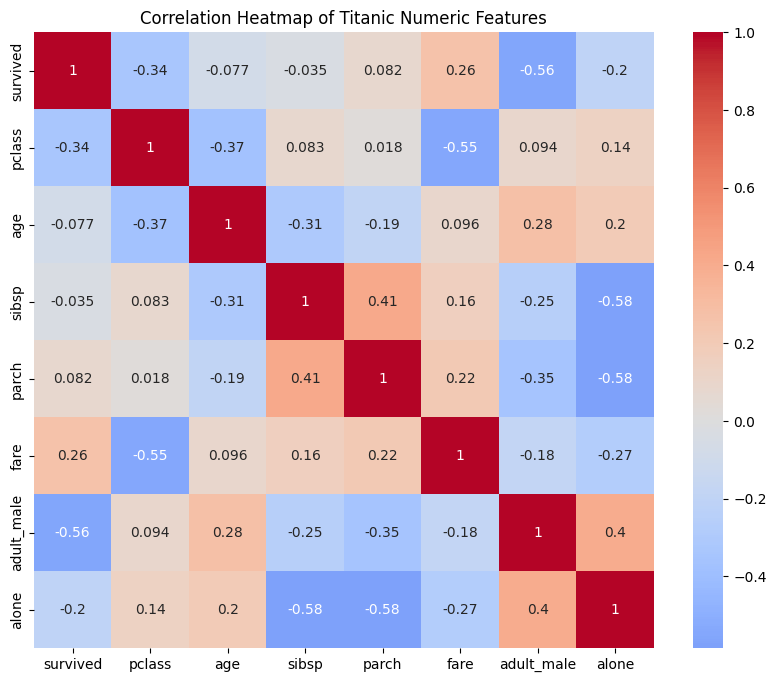

In [33]:
# Load Titanic dataset
titanic = sns.load_dataset('titanic')

# Inspect structure
titanic.info()
print(titanic.head(10))
print(titanic.isnull().sum())
print(titanic.describe())
print(titanic.corr(numeric_only=True))

# Compute correlation matrix
corr_matrix = titanic.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Titanic Numeric Features')
plt.show()


## Reflection 1: Dataset Inspection

1. **How many data instances are there?**  
   891 rows

2. **How many features are there?**  
   15 columns (including both numeric and categorical)

3. **What are the names?**  
 `survived`, `pclass`, `sex`, `age`, `sibsp`, `parch`, `fare`, `embarked`, `class`, `who`, `adult_male`, `deck`, `embark_town`, `alive`, `alone`

4. **Are there any missing values?**  
   Yes: `age`, `deck`, and `embark_town` have missing values

5. **Are there any non-numeric features?**  
    Yes: `sex`, `embarked`, `class`, `who`, `deck`, `embark_town`, `alive`

6. **Are the data instances sorted on any of the attributes?**  
   No, the dataset is not sorted by age, fare, or any other feature

7. **What are the units of age?**  
   Years

8. **What are the minimum, median, and max age?**  
   Min: 0.42, Median: ~28, Max: 80

9. **What two different features have the highest correlation?**  
**alone** and **sibsp** have the highest correlation at **–0.584**. This strong negative relationship means that passengers with siblings or spouses aboard were very unlikely to be traveling alone. It reflects a clear social structure: family members tended to travel together.

10.  **Are there any categorical features that might be useful for prediction?**  
   Yes: `sex`, `pclass`, `embarked`, `who`, `alone`, `embark_town`

## Section 2. Data Exploration and Preparation

### Section 2.1 — Explore Data Patterns and Distributions

#### Create a scatter matrix. 

array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='fare', ylabel='age'>,
        <Axes: xlabel='pclass', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='fare'>,
        <Axes: xlabel='fare', ylabel='fare'>,
        <Axes: xlabel='pclass', ylabel='fare'>],
       [<Axes: xlabel='age', ylabel='pclass'>,
        <Axes: xlabel='fare', ylabel='pclass'>,
        <Axes: xlabel='pclass', ylabel='pclass'>]], dtype=object)

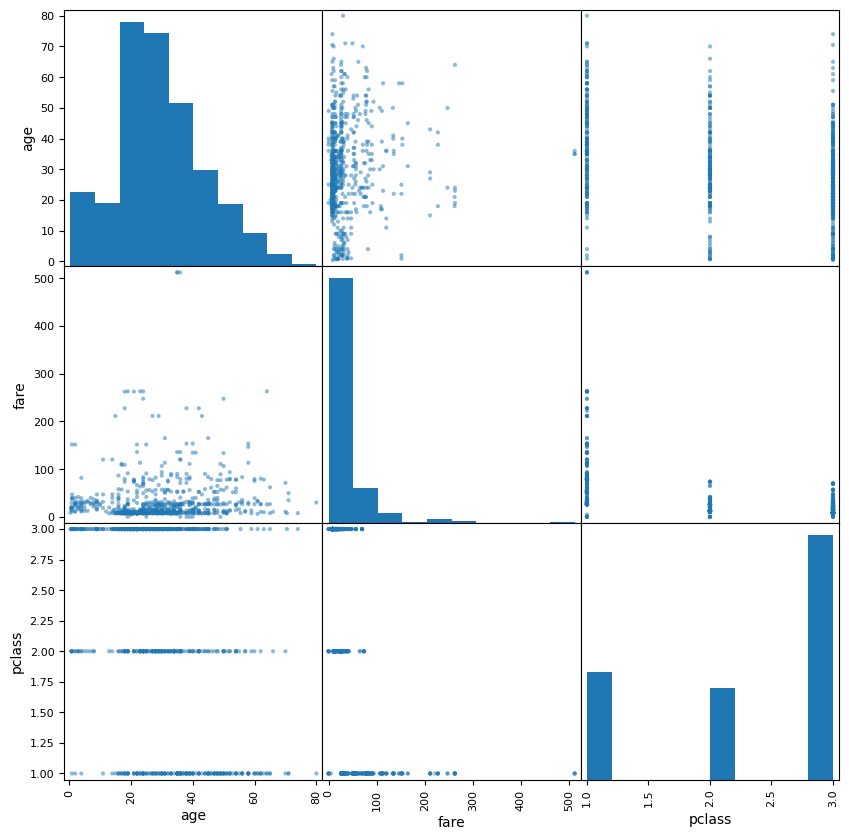

In [34]:
attributes = ['age', 'fare', 'pclass']
scatter_matrix(titanic[attributes], figsize=(10, 10))

#### Create a scatter plot of age vs fare, colored by gender:

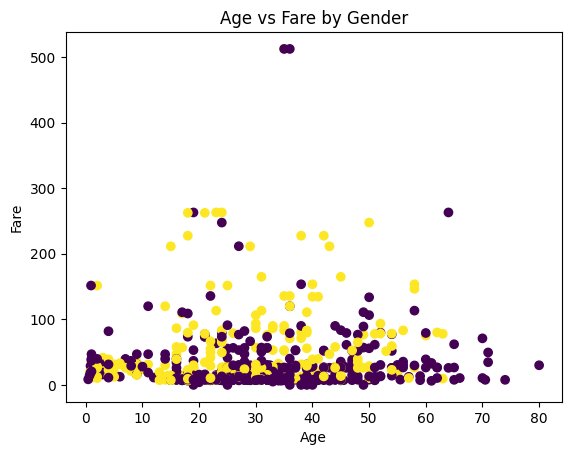

In [35]:
plt.scatter(titanic['age'], titanic['fare'], c=titanic['sex'].apply(lambda x: 0 if x == 'male' else 1))
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Age vs Fare by Gender')
plt.show()

#### Create a histogram of age:

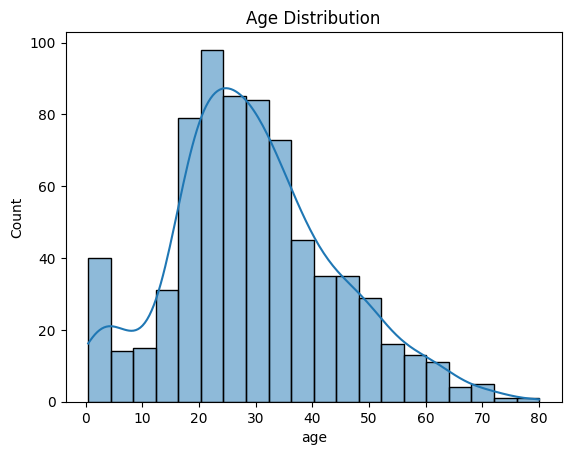

In [36]:
sns.histplot(titanic['age'], kde=True)
plt.title('Age Distribution')
plt.show()

#### Create a count plot for class and survival:

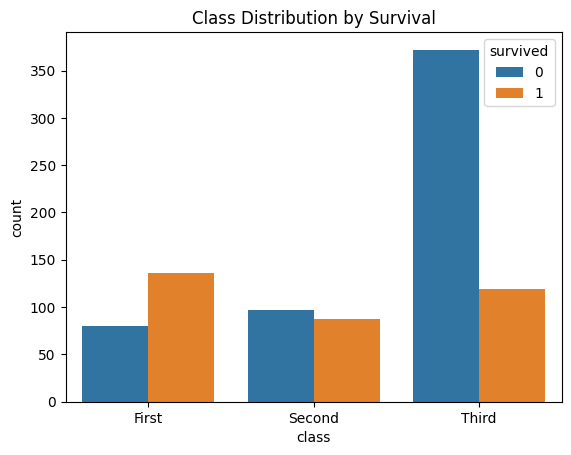

In [37]:
sns.countplot(x='class', hue='survived', data=titanic)
plt.title('Class Distribution by Survival')
plt.show()

#### Reflection 2.1:

**1. What patterns or anomalies do you notice?**  
- On the histogram for the age, the age distribution is right-skewed, with most passengers between 20 and 40 years old. Fare values show high variability, with some extreme outliers above $500. 
- In the scatter plot of age vs fare, females tend to appear in higher fare ranges. The scatter matrix shows weak linear relationships overall, but `fare` and `pclass` show a clear inverse pattern. 
- The count plot reveals a strong class imbalance and survival disparity across classes.

**2. Do any features stand out as potential predictors?**  
Yes. `sex` is a strong predictor, as survival rates differ sharply between males and females. `pclass` and `fare` reflect socioeconomic status and are both correlated with survival. `alone` and `family_size` (to be engineered later) may also capture social dynamics that influence survival.

**3. Are there any visible class imbalances?**  
Yes. The count plot shows that most passengers were in 3rd class, and the majority of them did not survive. In contrast, 1st class passengers had a much higher survival rate, while 2nd class was more balanced. This suggests that class played a significant role in survival outcomes.


### 2.2 Handle Missing Values and Clean Data

#### Impute missing values for age using the median:

In [38]:
# Replaced inplace=True to avoid chained assignment warning and ensure compatibility with future pandas versions
titanic['age'] = titanic['age'].fillna(titanic['age'].median())

#### Fill Missing Embark Town with Mode

In [39]:
# Used direct assignment instead of inplace=True to prevent chained assignment issues in pandas 3.0+
titanic['embark_town'] = titanic['embark_town'].fillna(titanic['embark_town'].mode()[0])

#### 2.3 Feature Engineering

In [40]:
### Create a new feature: Family size
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

In [41]:
### Convert categorical data to numeric:
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [42]:
### Create a binary feature for 'alone':

titanic['alone'] = titanic['alone'].astype(int)

#### Reflection 2.3

**Why might family size be a useful feature for predicting survival?**

Family size helps capture social dynamics on board. Passengers traveling with family may have had better support, coordination, or priority during evacuation. It  reflects group behavior, which could influence survival chances especially for children, women, or elderly passengers traveling with others.

**Why convert categorical data to numeric?**
Machine learning models require numeric input to process features effectively. Converting categorical variables like sex and embarked allows algorithms to include them in calculations, comparisons, and predictions. It’s a key step in preparing the data for modeling.


##### 3.1 Choose features and target

Select two or more input features (numerical for regression, numerical and/or categorical for classification)
Select a target variable (as applicable)
Classification: Categorical target variable (e.g., gender, species).
Justify your selection with reasoning.

For classification, we’ll use survived as the target variable.

Input features: age, fare, pclass, sex, family_size
Target: survived

####  3.2 Define X and y

Assign input features to X
Assign target variable to y (as applicable)

In [43]:
X = titanic[['age', 'fare', 'pclass', 'sex', 'family_size']]
y = titanic['survived']

### Adding the print statements to display the shapes and value counts for easy verification
print(X.shape)
print(X.head())

print(y.shape)
print(y.value_counts())

(891, 5)
    age     fare  pclass  sex  family_size
0  22.0   7.2500       3    0            2
1  38.0  71.2833       1    1            2
2  26.0   7.9250       3    1            1
3  35.0  53.1000       1    1            2
4  35.0   8.0500       3    0            1
(891,)
survived
0    549
1    342
Name: count, dtype: int64


#### Reflection 3:
**1. Why are these features selected?**
These features like `age`, `fare`, `pclass`, `sex`, and `family_size` are selected because they represent key factors that influenced survival on the Titanic. These features capture demographic (age, sex), socioeconomic (pclass, fare), and social structure (family_size) dimensions. Each one has shown meaningful patterns in earlier visualizations and is likely to contribute to model performance.


**2. Are there any features that are likely to be highly predictive of survival?**
Yes. `sex` is especially predictive females had a significantly higher survival rate. `pclass` is also important, with 1st class passengers surviving at much higher rates than those in 3rd class. `fare` supports this pattern, and `family_size` may help capture the impact of traveling with others, which could influence survival outcomes.


#### Section 4. Splitting
Split the data into training and test sets using train_test_split first and StratifiedShuffleSplit second. Compare.

#### Basic Train/Test split 
 

In [44]:
# Basic random split
X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(X, y, test_size=0.2, random_state=123)

print('Train size:', len(X_train_basic))
print('Test size:', len(X_test_basic))

Train size: 712
Test size: 179


#### Stratified Train/Test split

In [45]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

for train_indices, test_indices in splitter.split(X, y):
    train_set = X.iloc[train_indices]
    test_set = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]
## Added y_train and y_test for completeness since they were missing in the original code and we might need that for modeling. 
print('Train size:', len(train_set))
print('Test size:', len(test_set))

Train size: 712
Test size: 179


### Compare Results

### Comparison: Pclass Distribution Across Original, Train, and Test Sets

In [46]:
print("Original Class Distribution:\n", y.value_counts(normalize=True))
print("Train Set Class Distribution:\n", train_set['pclass'].value_counts(normalize=True))
print("Test Set Class Distribution:\n", test_set['pclass'].value_counts(normalize=True))

Original Class Distribution:
 survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64
Train Set Class Distribution:
 pclass
3    0.561798
1    0.227528
2    0.210674
Name: proportion, dtype: float64
Test Set Class Distribution:
 pclass
3    0.508380
1    0.301676
2    0.189944
Name: proportion, dtype: float64


#### Required Comparison: Survival Distribution Across Original, Train, and Test Sets

We check the survival distribution to make sure our training and test sets match the original data, this helps us answer the reflection and confirm that stratified splitting worked correctly.

In [47]:
print("Original Survival Distribution:\n", y.value_counts(normalize=True))
print("Train Set Survival Distribution:\n", y_train.value_counts(normalize=True))
print("Test Set Survival Distribution:\n", y_test.value_counts(normalize=True))

Original Survival Distribution:
 survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64
Train Set Survival Distribution:
 survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64
Test Set Survival Distribution:
 survived
0    0.614525
1    0.385475
Name: proportion, dtype: float64


#### Reflection 4:

**1. Why might stratification improve model performance?**
Stratification ensures that the training and test sets maintain the same class distribution as the original dataset. This is especially important when the target variable is imbalanced, like survival in the Titanic dataset. It helps the model learn from a representative sample and generalize better during evaluation.

**2. How close are the training and test distributions to the original dataset?**
The survival distributions in both the training and test sets closely match the original dataset. This confirms that the stratified split preserved class proportions and avoided sampling bias.


**3. Which split method produced better class balance?**

  StratifiedShuffleSplit produced better class balance. It maintained the original survival ratio more accurately than a basic random split, which can distort class proportions, especially in smaller datasets.

## Bonus — Apply Process to Breast Cancer Dataset
#### Goal: Repeat the same process on the Breast Cancer dataset and briefly present results.


dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
['malignant' 'benign']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1

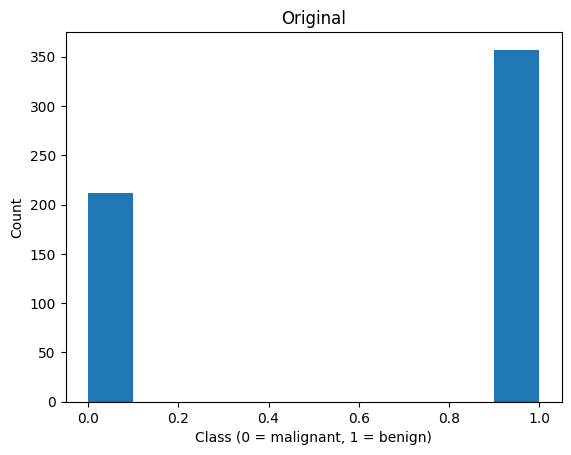

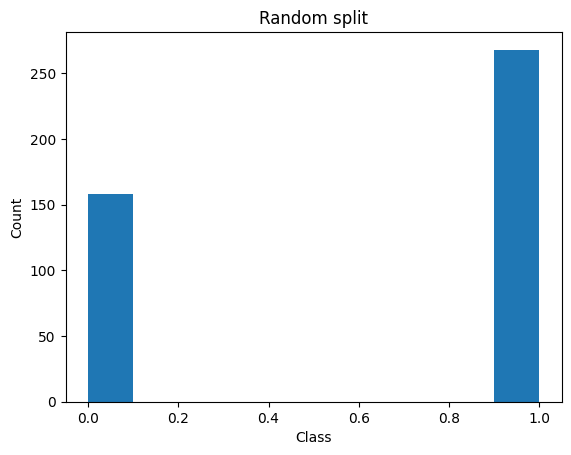

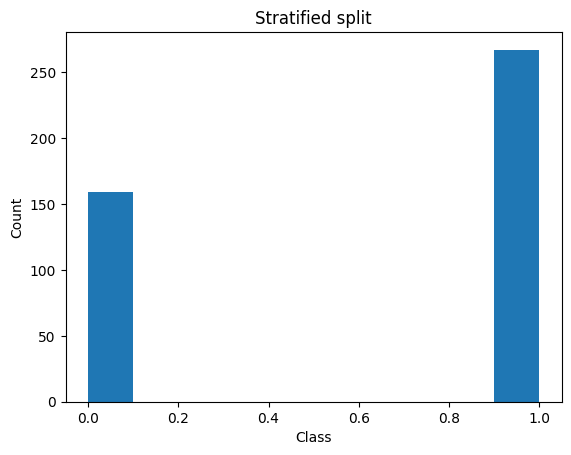

In [33]:
# Load Breast Cancer dataset
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
print(cancer.keys())
print(cancer['target_names'])
print(cancer['target'])

X = cancer['data']
y = cancer['target']

# Plot original distribution
import matplotlib.pyplot as plt
plt.hist(y)
plt.title('Original')
plt.xlabel('Class (0 = malignant, 1 = benign)')
plt.ylabel('Count')
plt.show()

# Train/test split (random)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

plt.hist(y_train)
plt.title('Random split')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, stratify=y)

plt.hist(y_train)
plt.title('Stratified split')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()